#### Implementarion of Semi-Supervised GANs 

In [2]:
import numpy as np
import os
import time
import keras

In [3]:
keras.__version__

'2.7.0'

In [4]:
def verifyDir(dir_path):
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [5]:
def normalize(x):
    x = (x.astype('float32') - 127.5) / 127.5
    return x

def unnormalize(x):
    x = 127.5*x+127.5
    return x
    
def plot_data(data, epoch, type_img, grid_size = [5, 5], OUT_PATH="", gray=False):
    # visualize some data generated by G
    size = grid_size[0] * grid_size[1]
    if data.shape[0] < size:
        size = 9
        grid_size=[3,3]
        data_concat = np.concatenate([data[:4], data[-5:]])
    else:
        data_concat = np.concatenate([data[:50], data[-50:]])
    # visualize some data generated by G
    _, axes = plt.subplots(figsize = grid_size, nrows = grid_size[0], ncols = grid_size[1],
                           sharey = True, sharex = True, gridspec_kw = {'wspace':0, 'hspace':0})

    for idx, ax in enumerate(axes.flatten()):
        ax.axis('off')
        if gray:
            ax.imshow(data_concat[idx], cmap = 'gray_r')
        else:
            ax.imshow(data_concat[idx])
    plt.tight_layout()
    plt.savefig(f"{OUT_PATH}{type_img}_{epoch}.png", bbox_inches='tight', pad_inches = 0.5)
    plt.clf()
    plt.cla()
    plt.close()

In [6]:
def load_real_samples():
  # load dataset
  (trainX, trainy), (testX, testy) = load_data()
  # expand to 3d, e.g. add channels
  X_train = np.expand_dims(trainX, axis=-1)
  X_test = np.expand_dims(testX, axis=-1)
  X_test = normalize(X_test)
  X_train = normalize(X_train)
  print(X_train.shape, trainy.shape, X_test.shape, testy.shape)
  return [X_train, trainy], [X_test, testy]

In [7]:
from keras import backend as K

# Custom Activation for the Unsupervised model

# custom activation function
def custom_activation(output):
    logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

In [8]:
#from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation, ReLU
from keras.layers import GlobalAveragePooling2D, BatchNormalization

# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10, learning_rate = 0.0001, metrics_list=["accuracy"]):
  # image input
  in_image = Input(shape=in_shape)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output layer nodes
  fe = Dense(n_classes)(fe)
  
  # supervised output
  c_out_layer = Activation('softmax')(fe)
  
  # optimizer
  optimizer_grad = Adam(lr=learning_rate, beta_1=0.15)

  # define and compile supervised discriminator model
  supervised_model = Model(in_image, c_out_layer)
  supervised_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_grad, metrics=metrics_list)
  
  # unsupervised output
  d_out_layer = Lambda(custom_activation)(fe)
  
  # define and compile unsupervised discriminator model
  unsupervised_model = Model(in_image, d_out_layer)
  unsupervised_model.compile(loss='binary_crossentropy', optimizer=optimizer_grad, metrics=['accuracy'])
  
  return unsupervised_model, supervised_model

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation, ReLU
from keras.layers import GlobalAveragePooling2D, BatchNormalization

# define the standalone generator model
def define_generator(latent_dim):
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # define model
  generator_model = Model(in_lat, out_layer)
  return generator_model

In [10]:
from tensorflow.keras.optimizers import Adam
from keras.models import Model

# We let the unsupervised model as not trainable, because we gonna trin the weights of the supervised model 
# (which shares weights with the unsupervised).

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator_model, unsupervised_model, optimizer_grad = Adam(learning_rate=0.0002, beta_1=0.5)):
  # make weights in the discriminator not trainable
  unsupervised_model.trainable = False
  
  # connect image output from generator as input to discriminator
  gan_output = unsupervised_model(generator_model.output)
  
  # define gan model as taking noise and outputting a classification
  model = Model(generator_model.input, gan_output)
  
  # compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer_grad)
  return model

In [11]:
import numpy as np
from numpy.random import randn, randint

# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_classes=10, n_samples=None, label_rate=None, seed=42):
  X, y = dataset
  X_list, y_list = list(), list()
  if n_samples is not None:
    n_per_class = int(n_samples / n_classes)
  
  random_state = np.random.RandomState(seed=seed)
  
  for i in range(n_classes):
    # get all images for this class
    X_with_class = X[y == i]
    # choose random instances
    if n_samples is not None:
      ix = random_state.randint(0, len(X_with_class), n_per_class)
    if label_rate is not None:
      ix = random_state.randint(0, len(X_with_class), int(len(X_with_class)*label_rate))
    # add to list
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
  return np.asarray(X_list), np.asarray(y_list)


# select real samples
def generate_real_samples(dataset, n_samples=100):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = np.ones((n_samples, 1))
  return [X, labels], y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples=100):
  # generate points in the latent space
  z_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = z_input.reshape(n_samples, latent_dim)
  return z_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples=100):
  # generate points in latent space
  z_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict(z_input)
  # create class labels
  y = np.zeros((n_samples, 1))
  return images, y

In [12]:
from keras.datasets.mnist import load_data

import numpy as np

# load the images CIFAR10
# load the images MNIST
def load_real_samples():
  # load dataset
  (trainX, trainy), (testX, testy) = load_data()
  # expand to 3d, e.g. add channels
  X_train = np.expand_dims(trainX, axis=-1)
  X_test = np.expand_dims(testX, axis=-1)
  X_test = normalize(X_test)
  X_train = normalize(X_train)
  print(X_train.shape, trainy.shape, X_test.shape, testy.shape)
  return [X_train, trainy], [X_test, testy]

In [13]:
# load image data
dataset_train, dataset_test = load_real_samples()

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


#### Parameters

In [14]:
input_shape = (28, 28, 1)
num_classes = 10

learning_rate = 2e-4
latent_dim = 100

epochs=2
batch_size=128

labeled_rate = 1/600
labeled_samples = int(dataset_train[0].shape[0]*labeled_rate)

In [15]:
LOG_PATH = f"Logs/SSGAN_MNIST/Classifier_{labeled_samples}/"
verifyDir(LOG_PATH)

#### Creating Models

In [16]:
metrics_list=["accuracy", "mse"]

In [17]:
# create the discriminator models
unsupervised_model, supervised_model = define_discriminator(in_shape=input_shape, 
                                                            n_classes=num_classes, 
                                                            learning_rate = learning_rate,
                                                            metrics_list=metrics_list)
# create the generator
generator_model = define_generator(latent_dim=latent_dim)

C:\Users\balaj\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
supervised_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0     

In [19]:
unsupervised_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0   

In [20]:
generator_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

In [21]:
# create the gan
from tensorflow.keras.optimizers import Adam
opt_gan = Adam(lr=learning_rate, beta_1=0.15)

gan_model = define_gan(generator_model, unsupervised_model, optimizer_grad = opt_gan)

In [22]:
gan_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

#### Training

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# train the generator and discriminator
def train_gan(generator_model, unsupervised_model, supervised_model, gan_model, 
              dataset_train, dataset_test, 
              latent_dim=100, n_epochs=20, n_batch=100, 
              n_classes=10, label_rate=None, n_samples=None, 
              unnormalize_image=False, LOG_PATH=""):
    
    # select supervised dataset_train
    X_sup, y_sup = select_supervised_samples(dataset_train, 
                                             n_classes=n_classes, 
                                             label_rate=label_rate, 
                                             n_samples=n_samples)
    
    print("Supervised samples:", X_sup.shape, y_sup.shape)
    
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset_train[0].shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print('n_epochs=%d, n_batch=%d, batch/epoch=%d, steps=%d' % (n_epochs, n_batch, bat_per_epo, n_steps))
    
    # manually enumerate epochs
    f_history = open(f"{LOG_PATH}SSL_GAN.csv", "w")
    
    f_history.write("step;generator_loss;"\
                    "unsupervised_real_loss;unsupervised_real_acc;"\
                    "unsupervised_fake_loss;unsupervised_fake_acc;"\
                    "supervised_loss;supervised_acc;"\
                    "train_loss;test_loss;"\
                    "train_mse;test_mse;"\
                    "train_acc;test_acc\n")
    
    #for epoch in n_epochs:
    #    for batch in range(bat_per_epo):
    for step in range(1,n_steps+1):
#         t_start = time.time()
        # update supervised discriminator (c)
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], n_samples=n_batch)
        sup_results = supervised_model.train_on_batch(Xsup_real, ysup_real)
        c_loss, c_acc = sup_results[0], sup_results[1]
        
        # update unsupervised discriminator (d)
        [X_real, _], y_real = generate_real_samples(dataset_train, n_samples=n_batch)
        d_loss1, real_acc = unsupervised_model.train_on_batch(X_real, y_real)
        
        X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, n_samples=n_batch)
        d_loss2, fake_acc = unsupervised_model.train_on_batch(X_fake, y_fake)
        
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_samples=n_batch), np.ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
#         t_total = (time.time() - t_start)
        # summarize loss on this batch
    
        # Train - Test
        X_train, y_train = dataset_train
        loss_train, acc_train, mse_train = supervised_model.evaluate(X_train, y_train, verbose=0)

        # evaluate the test classifier model
        X_test, y_test = dataset_test
        loss_test, acc_test, mse_test = supervised_model.evaluate(X_test, y_test, verbose=0)
        
        # Log
        print('epoch: %d | step: %d | Train: G_Loss: %.3f, ' \
              'D_unsup_loss_real: %.3f, D_unsup_acc_real:  %.2f, ' \
              'D_unsup_loss_fake: %.3f, D_unsup_acc_fake: %.2f, ' \
              'D_sup_loss: %.3f, D_sup_acc: %.2f ' \
              'Train acc: %.3f Test acc: %.3f ' %(int(step/bat_per_epo), step, g_loss,
                                                d_loss1, real_acc*100,
                                                d_loss2, fake_acc*100,
                                                c_loss, c_acc*100,
                                                acc_train*100, acc_test*100))#, end = '\r')
        
        f_history.write(f"{step};{g_loss};"\
                        f"{d_loss1};{real_acc*100};"\
                        f"{d_loss2};{fake_acc*100};"\
                        f"{c_loss};{c_acc*100};"\
                        f"{loss_train};{loss_test};"\
                        f"{mse_train};{mse_test};"\
                        f"{acc_train*100};{acc_test*100}\n")
        
        if step==1:
            # prepare fake examples
            X_generated, _ = generate_fake_samples(generator_model, latent_dim, n_samples=100)

            if unnormalize_image:
              # plot real samples
              plot_data(unnormalize(X_test).astype(int), 0, "test", grid_size = [10, 10], OUT_PATH=LOG_PATH)
            
              # scale from [-1,1] to [0,1]
              plot_data(unnormalize(X_generated).astype(int), step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH)
            
            else:
              # plot real samples
              plot_data(X_test, 0, "test", grid_size = [10, 10], OUT_PATH=LOG_PATH, gray=True)
            
              # scale from [-1,1] to [0,1]
              plot_data(X_generated, step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH, gray=True)
            
            # evaluate train set
            X_train, y_train = dataset_train
            train_results = supervised_model.evaluate(X_train, y_train, verbose=1)
            acc = train_results[1]
            print('Train Classifier Accuracy: %.3f%%\n' % (acc * 100))
            
            # evaluate the test classifier model
            X_test, y_test = dataset_test
            test_results = supervised_model.evaluate(X_test, y_test, verbose=1)
            acc = test_results[1]
            print('Test Classifier Accuracy: %.3f%% \n' % (acc * 100))
            
            # save the generator model
            filename2 = f'{LOG_PATH}generator_model_{step}.h5'
            generator_model.save(filename2)
            # save the classifier model
            filename3 = f'{LOG_PATH}supervised_model_{step}.h5'
            supervised_model.save(filename3)
            
            print('>Saving models Generator: %s and Supervised: %s' % (filename2, filename3))
        
        elif (step) % (100) == 0:
            # prepare fake examples
            X_generated, _ = generate_fake_samples(generator_model, latent_dim, n_samples=100)

            if unnormalize_image:
              # scale from [-1,1] to [0,1]
              plot_data(unnormalize(X_generated).astype(int), step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH)
            
            else:
              # scale from [-1,1] to [0,1]
              plot_data(X_generated, step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH, gray=True)
            
        elif (step) % (bat_per_epo) == 0:
            # prepare fake examples
            X_generated, _ = generate_fake_samples(generator_model, latent_dim, n_samples=100)

            if unnormalize_image:
              # scale from [-1,1] to [0,1]
              plot_data(unnormalize(X_generated).astype(int), step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH)
            
            else:
              # scale from [-1,1] to [0,1]
              plot_data(X_generated, step, "generated", grid_size = [10, 10], OUT_PATH=LOG_PATH, gray=True)
            
            # evaluate train set
            X_train, y_train = dataset_train
            train_results = supervised_model.evaluate(X_train, y_train, verbose=1)
            acc = train_results[1]
            print('Train Classifier Accuracy: %.3f%%\n' % (acc * 100))
            
            # evaluate the test classifier model
            X_test, y_test = dataset_test
            test_results = supervised_model.evaluate(X_test, y_test, verbose=1)
            acc = test_results[1]
            print('Test Classifier Accuracy: %.3f%% \n' % (acc * 100))
            
            # save the generator model
            filename2 = f'{LOG_PATH}generator_model_{step}.h5'
            generator_model.save(filename2)
            # save the classifier model
            filename3 = f'{LOG_PATH}supervised_model_{step}.h5'
            supervised_model.save(filename3)
            
            print('>Saving models Generator: %s and Supervised: %s' % (filename2, filename3))
    
    f_history.close()

In [24]:
%%time
train_gan(generator_model, unsupervised_model, supervised_model, gan_model, 
      dataset_train, dataset_test, latent_dim=latent_dim, 
      n_epochs=epochs, n_batch=batch_size, n_classes=num_classes, 
      # n_samples=labeled_samples)
      label_rate=labeled_rate, LOG_PATH=LOG_PATH,
      unnormalize_image=False)

Supervised samples: (94, 28, 28, 1) (94,)
n_epochs=2, n_batch=128, batch/epoch=468, steps=936
epoch: 0 | step: 1 | Train: G_Loss: 0.095, D_unsup_loss_real: 0.096, D_unsup_acc_real:  100.00, D_unsup_loss_fake: 2.399, D_unsup_acc_fake: 0.00, D_sup_loss: 2.306, D_sup_acc: 7.81 Train acc: 12.188 Test acc: 13.020 
1875/1875 [==============================] - 11s 6ms/step - loss: 2.2946 - accuracy: 0.1219 - mse: 27.3046
Train Classifier Accuracy: 12.188%

313/313 [==============================] - 2s 6ms/step - loss: 2.2945 - accuracy: 0.1302 - mse: 27.2504
Test Classifier Accuracy: 13.020% 

>Saving models Generator: Logs/SSGAN_MNIST/Classifier_100/generator_model_1.h5 and Supervised: Logs/SSGAN_MNIST/Classifier_100/supervised_model_1.h5
epoch: 0 | step: 2 | Train: G_Loss: 0.095, D_unsup_loss_real: 0.094, D_unsup_acc_real:  100.00, D_unsup_loss_fake: 2.398, D_unsup_acc_fake: 0.00, D_sup_loss: 2.282, D_sup_acc: 17.97 Train acc: 25.892 Test acc: 25.890 
epoch: 0 | step: 3 | Train: G_Loss: 0.0

epoch: 0 | step: 36 | Train: G_Loss: 0.655, D_unsup_loss_real: 0.651, D_unsup_acc_real:  58.59, D_unsup_loss_fake: 1.386, D_unsup_acc_fake: 0.00, D_sup_loss: 0.422, D_sup_acc: 89.06 Train acc: 73.285 Test acc: 75.020 
epoch: 0 | step: 37 | Train: G_Loss: 1.000, D_unsup_loss_real: 0.272, D_unsup_acc_real:  95.31, D_unsup_loss_fake: 1.313, D_unsup_acc_fake: 0.00, D_sup_loss: 0.408, D_sup_acc: 89.06 Train acc: 74.630 Test acc: 76.390 
epoch: 0 | step: 38 | Train: G_Loss: 0.671, D_unsup_loss_real: 0.634, D_unsup_acc_real:  61.72, D_unsup_loss_fake: 1.328, D_unsup_acc_fake: 0.00, D_sup_loss: 0.566, D_sup_acc: 85.16 Train acc: 69.848 Test acc: 71.330 
epoch: 0 | step: 39 | Train: G_Loss: 0.934, D_unsup_loss_real: 0.322, D_unsup_acc_real:  91.41, D_unsup_loss_fake: 1.359, D_unsup_acc_fake: 0.00, D_sup_loss: 0.590, D_sup_acc: 80.47 Train acc: 74.098 Test acc: 75.770 
epoch: 0 | step: 40 | Train: G_Loss: 0.755, D_unsup_loss_real: 0.651, D_unsup_acc_real:  60.16, D_unsup_loss_fake: 1.471, D_unsu

epoch: 0 | step: 74 | Train: G_Loss: 0.803, D_unsup_loss_real: 0.783, D_unsup_acc_real:  40.62, D_unsup_loss_fake: 0.971, D_unsup_acc_fake: 17.97, D_sup_loss: 0.370, D_sup_acc: 94.53 Train acc: 74.400 Test acc: 76.100 
epoch: 0 | step: 75 | Train: G_Loss: 0.772, D_unsup_loss_real: 0.773, D_unsup_acc_real:  42.19, D_unsup_loss_fake: 0.947, D_unsup_acc_fake: 19.53, D_sup_loss: 0.392, D_sup_acc: 95.31 Train acc: 74.162 Test acc: 75.620 
epoch: 0 | step: 76 | Train: G_Loss: 0.728, D_unsup_loss_real: 0.809, D_unsup_acc_real:  35.94, D_unsup_loss_fake: 0.986, D_unsup_acc_fake: 17.19, D_sup_loss: 0.403, D_sup_acc: 93.75 Train acc: 74.580 Test acc: 76.010 
epoch: 0 | step: 77 | Train: G_Loss: 0.777, D_unsup_loss_real: 0.814, D_unsup_acc_real:  41.41, D_unsup_loss_fake: 1.022, D_unsup_acc_fake: 16.41, D_sup_loss: 0.427, D_sup_acc: 90.62 Train acc: 75.025 Test acc: 76.850 
epoch: 0 | step: 78 | Train: G_Loss: 0.774, D_unsup_loss_real: 0.755, D_unsup_acc_real:  47.66, D_unsup_loss_fake: 0.909, D_

epoch: 0 | step: 112 | Train: G_Loss: 0.799, D_unsup_loss_real: 0.784, D_unsup_acc_real:  39.06, D_unsup_loss_fake: 0.889, D_unsup_acc_fake: 31.25, D_sup_loss: 0.304, D_sup_acc: 99.22 Train acc: 76.627 Test acc: 78.050 
epoch: 0 | step: 113 | Train: G_Loss: 0.740, D_unsup_loss_real: 0.828, D_unsup_acc_real:  39.06, D_unsup_loss_fake: 0.916, D_unsup_acc_fake: 21.88, D_sup_loss: 0.298, D_sup_acc: 98.44 Train acc: 76.785 Test acc: 78.350 
epoch: 0 | step: 114 | Train: G_Loss: 0.753, D_unsup_loss_real: 0.815, D_unsup_acc_real:  39.06, D_unsup_loss_fake: 0.952, D_unsup_acc_fake: 24.22, D_sup_loss: 0.283, D_sup_acc: 98.44 Train acc: 76.673 Test acc: 78.110 
epoch: 0 | step: 115 | Train: G_Loss: 0.757, D_unsup_loss_real: 0.760, D_unsup_acc_real:  45.31, D_unsup_loss_fake: 0.906, D_unsup_acc_fake: 18.75, D_sup_loss: 0.333, D_sup_acc: 97.66 Train acc: 76.908 Test acc: 78.330 
epoch: 0 | step: 116 | Train: G_Loss: 0.734, D_unsup_loss_real: 0.784, D_unsup_acc_real:  39.06, D_unsup_loss_fake: 0.96

epoch: 0 | step: 150 | Train: G_Loss: 0.792, D_unsup_loss_real: 0.752, D_unsup_acc_real:  45.31, D_unsup_loss_fake: 0.836, D_unsup_acc_fake: 36.72, D_sup_loss: 0.255, D_sup_acc: 99.22 Train acc: 77.447 Test acc: 78.800 
epoch: 0 | step: 151 | Train: G_Loss: 0.806, D_unsup_loss_real: 0.729, D_unsup_acc_real:  46.88, D_unsup_loss_fake: 0.809, D_unsup_acc_fake: 42.19, D_sup_loss: 0.238, D_sup_acc: 97.66 Train acc: 77.315 Test acc: 78.930 
epoch: 0 | step: 152 | Train: G_Loss: 0.824, D_unsup_loss_real: 0.739, D_unsup_acc_real:  50.78, D_unsup_loss_fake: 0.894, D_unsup_acc_fake: 30.47, D_sup_loss: 0.220, D_sup_acc: 99.22 Train acc: 77.503 Test acc: 79.110 
epoch: 0 | step: 153 | Train: G_Loss: 0.798, D_unsup_loss_real: 0.776, D_unsup_acc_real:  44.53, D_unsup_loss_fake: 0.841, D_unsup_acc_fake: 40.62, D_sup_loss: 0.222, D_sup_acc: 98.44 Train acc: 77.600 Test acc: 78.900 
epoch: 0 | step: 154 | Train: G_Loss: 0.820, D_unsup_loss_real: 0.743, D_unsup_acc_real:  45.31, D_unsup_loss_fake: 0.91

epoch: 0 | step: 188 | Train: G_Loss: 0.820, D_unsup_loss_real: 0.746, D_unsup_acc_real:  50.78, D_unsup_loss_fake: 0.885, D_unsup_acc_fake: 42.19, D_sup_loss: 0.186, D_sup_acc: 100.00 Train acc: 77.492 Test acc: 78.670 
epoch: 0 | step: 189 | Train: G_Loss: 0.827, D_unsup_loss_real: 0.707, D_unsup_acc_real:  50.00, D_unsup_loss_fake: 0.847, D_unsup_acc_fake: 40.62, D_sup_loss: 0.208, D_sup_acc: 99.22 Train acc: 77.330 Test acc: 78.480 
epoch: 0 | step: 190 | Train: G_Loss: 0.832, D_unsup_loss_real: 0.722, D_unsup_acc_real:  52.34, D_unsup_loss_fake: 0.769, D_unsup_acc_fake: 50.00, D_sup_loss: 0.186, D_sup_acc: 99.22 Train acc: 77.318 Test acc: 78.460 
epoch: 0 | step: 191 | Train: G_Loss: 0.828, D_unsup_loss_real: 0.757, D_unsup_acc_real:  49.22, D_unsup_loss_fake: 0.827, D_unsup_acc_fake: 42.19, D_sup_loss: 0.183, D_sup_acc: 98.44 Train acc: 77.250 Test acc: 78.510 
epoch: 0 | step: 192 | Train: G_Loss: 0.816, D_unsup_loss_real: 0.732, D_unsup_acc_real:  49.22, D_unsup_loss_fake: 0.8

epoch: 0 | step: 226 | Train: G_Loss: 0.885, D_unsup_loss_real: 0.665, D_unsup_acc_real:  55.47, D_unsup_loss_fake: 0.784, D_unsup_acc_fake: 48.44, D_sup_loss: 0.173, D_sup_acc: 100.00 Train acc: 77.882 Test acc: 79.390 
epoch: 0 | step: 227 | Train: G_Loss: 0.854, D_unsup_loss_real: 0.696, D_unsup_acc_real:  50.78, D_unsup_loss_fake: 0.787, D_unsup_acc_fake: 51.56, D_sup_loss: 0.156, D_sup_acc: 100.00 Train acc: 77.925 Test acc: 79.360 
epoch: 0 | step: 228 | Train: G_Loss: 0.879, D_unsup_loss_real: 0.715, D_unsup_acc_real:  53.91, D_unsup_loss_fake: 0.817, D_unsup_acc_fake: 48.44, D_sup_loss: 0.166, D_sup_acc: 99.22 Train acc: 77.698 Test acc: 79.450 
epoch: 0 | step: 229 | Train: G_Loss: 0.832, D_unsup_loss_real: 0.684, D_unsup_acc_real:  53.12, D_unsup_loss_fake: 0.781, D_unsup_acc_fake: 53.91, D_sup_loss: 0.133, D_sup_acc: 100.00 Train acc: 77.728 Test acc: 79.310 
epoch: 0 | step: 230 | Train: G_Loss: 0.901, D_unsup_loss_real: 0.714, D_unsup_acc_real:  49.22, D_unsup_loss_fake: 0

epoch: 0 | step: 264 | Train: G_Loss: 0.796, D_unsup_loss_real: 0.752, D_unsup_acc_real:  48.44, D_unsup_loss_fake: 0.799, D_unsup_acc_fake: 50.00, D_sup_loss: 0.145, D_sup_acc: 100.00 Train acc: 79.750 Test acc: 81.500 
epoch: 0 | step: 265 | Train: G_Loss: 0.889, D_unsup_loss_real: 0.672, D_unsup_acc_real:  52.34, D_unsup_loss_fake: 0.855, D_unsup_acc_fake: 43.75, D_sup_loss: 0.119, D_sup_acc: 100.00 Train acc: 79.540 Test acc: 81.170 
epoch: 0 | step: 266 | Train: G_Loss: 0.847, D_unsup_loss_real: 0.727, D_unsup_acc_real:  51.56, D_unsup_loss_fake: 0.765, D_unsup_acc_fake: 53.91, D_sup_loss: 0.118, D_sup_acc: 100.00 Train acc: 79.425 Test acc: 81.010 
epoch: 0 | step: 267 | Train: G_Loss: 0.921, D_unsup_loss_real: 0.646, D_unsup_acc_real:  53.91, D_unsup_loss_fake: 0.805, D_unsup_acc_fake: 42.19, D_sup_loss: 0.134, D_sup_acc: 100.00 Train acc: 79.415 Test acc: 80.980 
epoch: 0 | step: 268 | Train: G_Loss: 0.920, D_unsup_loss_real: 0.697, D_unsup_acc_real:  54.69, D_unsup_loss_fake: 

epoch: 0 | step: 302 | Train: G_Loss: 0.952, D_unsup_loss_real: 0.660, D_unsup_acc_real:  60.94, D_unsup_loss_fake: 0.761, D_unsup_acc_fake: 52.34, D_sup_loss: 0.127, D_sup_acc: 100.00 Train acc: 80.695 Test acc: 82.490 
epoch: 0 | step: 303 | Train: G_Loss: 0.930, D_unsup_loss_real: 0.632, D_unsup_acc_real:  56.25, D_unsup_loss_fake: 0.798, D_unsup_acc_fake: 52.34, D_sup_loss: 0.122, D_sup_acc: 99.22 Train acc: 80.987 Test acc: 82.910 
epoch: 0 | step: 304 | Train: G_Loss: 0.876, D_unsup_loss_real: 0.683, D_unsup_acc_real:  53.12, D_unsup_loss_fake: 0.792, D_unsup_acc_fake: 49.22, D_sup_loss: 0.095, D_sup_acc: 100.00 Train acc: 81.462 Test acc: 83.210 
epoch: 0 | step: 305 | Train: G_Loss: 0.939, D_unsup_loss_real: 0.587, D_unsup_acc_real:  64.84, D_unsup_loss_fake: 0.803, D_unsup_acc_fake: 50.78, D_sup_loss: 0.115, D_sup_acc: 99.22 Train acc: 81.123 Test acc: 83.010 
epoch: 0 | step: 306 | Train: G_Loss: 0.922, D_unsup_loss_real: 0.739, D_unsup_acc_real:  48.44, D_unsup_loss_fake: 0.

epoch: 0 | step: 340 | Train: G_Loss: 0.936, D_unsup_loss_real: 0.718, D_unsup_acc_real:  46.09, D_unsup_loss_fake: 0.780, D_unsup_acc_fake: 53.12, D_sup_loss: 0.121, D_sup_acc: 100.00 Train acc: 82.555 Test acc: 83.960 
epoch: 0 | step: 341 | Train: G_Loss: 0.917, D_unsup_loss_real: 0.676, D_unsup_acc_real:  55.47, D_unsup_loss_fake: 0.784, D_unsup_acc_fake: 53.91, D_sup_loss: 0.092, D_sup_acc: 100.00 Train acc: 82.437 Test acc: 83.930 
epoch: 0 | step: 342 | Train: G_Loss: 0.945, D_unsup_loss_real: 0.669, D_unsup_acc_real:  56.25, D_unsup_loss_fake: 0.813, D_unsup_acc_fake: 53.12, D_sup_loss: 0.109, D_sup_acc: 100.00 Train acc: 82.065 Test acc: 83.750 
epoch: 0 | step: 343 | Train: G_Loss: 0.961, D_unsup_loss_real: 0.623, D_unsup_acc_real:  59.38, D_unsup_loss_fake: 0.744, D_unsup_acc_fake: 58.59, D_sup_loss: 0.139, D_sup_acc: 98.44 Train acc: 82.152 Test acc: 83.740 
epoch: 0 | step: 344 | Train: G_Loss: 0.954, D_unsup_loss_real: 0.702, D_unsup_acc_real:  55.47, D_unsup_loss_fake: 0

epoch: 0 | step: 378 | Train: G_Loss: 1.092, D_unsup_loss_real: 0.597, D_unsup_acc_real:  60.94, D_unsup_loss_fake: 0.765, D_unsup_acc_fake: 57.81, D_sup_loss: 0.087, D_sup_acc: 100.00 Train acc: 83.468 Test acc: 84.790 
epoch: 0 | step: 379 | Train: G_Loss: 1.017, D_unsup_loss_real: 0.731, D_unsup_acc_real:  50.78, D_unsup_loss_fake: 0.672, D_unsup_acc_fake: 64.06, D_sup_loss: 0.090, D_sup_acc: 100.00 Train acc: 83.358 Test acc: 84.560 
epoch: 0 | step: 380 | Train: G_Loss: 0.944, D_unsup_loss_real: 0.677, D_unsup_acc_real:  57.03, D_unsup_loss_fake: 0.699, D_unsup_acc_fake: 63.28, D_sup_loss: 0.103, D_sup_acc: 100.00 Train acc: 83.688 Test acc: 85.110 
epoch: 0 | step: 381 | Train: G_Loss: 0.988, D_unsup_loss_real: 0.666, D_unsup_acc_real:  52.34, D_unsup_loss_fake: 0.728, D_unsup_acc_fake: 56.25, D_sup_loss: 0.102, D_sup_acc: 99.22 Train acc: 83.810 Test acc: 85.220 
epoch: 0 | step: 382 | Train: G_Loss: 0.915, D_unsup_loss_real: 0.687, D_unsup_acc_real:  55.47, D_unsup_loss_fake: 0

epoch: 0 | step: 416 | Train: G_Loss: 0.984, D_unsup_loss_real: 0.700, D_unsup_acc_real:  56.25, D_unsup_loss_fake: 0.714, D_unsup_acc_fake: 56.25, D_sup_loss: 0.083, D_sup_acc: 100.00 Train acc: 85.050 Test acc: 86.430 
epoch: 0 | step: 417 | Train: G_Loss: 0.977, D_unsup_loss_real: 0.640, D_unsup_acc_real:  59.38, D_unsup_loss_fake: 0.801, D_unsup_acc_fake: 51.56, D_sup_loss: 0.083, D_sup_acc: 100.00 Train acc: 85.242 Test acc: 86.610 
epoch: 0 | step: 418 | Train: G_Loss: 0.946, D_unsup_loss_real: 0.673, D_unsup_acc_real:  60.16, D_unsup_loss_fake: 0.788, D_unsup_acc_fake: 54.69, D_sup_loss: 0.088, D_sup_acc: 100.00 Train acc: 85.122 Test acc: 86.440 
epoch: 0 | step: 419 | Train: G_Loss: 0.943, D_unsup_loss_real: 0.706, D_unsup_acc_real:  50.00, D_unsup_loss_fake: 0.731, D_unsup_acc_fake: 55.47, D_sup_loss: 0.102, D_sup_acc: 99.22 Train acc: 85.135 Test acc: 86.350 
epoch: 0 | step: 420 | Train: G_Loss: 0.939, D_unsup_loss_real: 0.655, D_unsup_acc_real:  57.03, D_unsup_loss_fake: 0

KeyboardInterrupt: 

#### Testing

In [25]:
dataset_train, dataset_test = load_real_samples()

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [26]:
from tensorflow.keras.models import load_model

In [27]:
last_step = int(dataset_train[0].shape[0]/batch_size)*epochs
last_step

936

In [28]:
supervised_model = load_model(f'{LOG_PATH}supervised_model_{last_step}.h5')

In [29]:
X_train, y_train = dataset_train
train_results = supervised_model.evaluate(X_train, y_train, verbose=0)
print('Train Classifier Accuracy: %.3f%%\n' % (train_results[1] * 100))

Train Classifier Accuracy: 89.997%



In [30]:
X_test, y_test = dataset_test
test_results = supervised_model.evaluate(X_test, y_test, verbose=0)
print('Test Classifier Accuracy: %.3f%%\n' % (test_results[1] * 100))

Test Classifier Accuracy: 90.980%



#### Plotting

In [31]:
import pandas as pd

In [32]:
results_file = pd.read_csv(f"{LOG_PATH}SSL_GAN.csv", sep=";")

In [33]:
log_file = results_file.iloc[:,1:]
log_file

,generator_loss,unsupervised_real_loss,unsupervised_real_acc,unsupervised_fake_loss,unsupervised_fake_acc,supervised_loss,supervised_acc,train_loss,test_loss,train_mse,test_mse,train_acc,test_acc
0,0.095358,0.096290,100.00000,2.398713,0.00000,2.306213,7.81250,2.294571,2.294456,27.304590,27.250359,12.188333,13.020000
1,0.095493,0.094424,100.00000,2.397624,0.00000,2.282266,17.96875,2.282531,2.282672,27.304592,27.250366,25.891668,25.889999
2,0.095627,0.092713,100.00000,2.396710,0.00000,2.272137,23.43750,2.269751,2.269892,27.304594,27.250378,20.548333,20.080000
3,0.095734,0.091367,100.00000,2.395915,0.00000,2.250144,31.25000,2.257652,2.257555,27.304600,27.250385,19.428334,19.239999
4,0.095775,0.090197,100.00000,2.396577,0.00000,2.238833,20.31250,2.241114,2.239968,27.304594,27.250376,37.570000,37.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1.000661,0.619943,61.71875,0.698382,57.81250,0.089123,100.00000,0.522035,0.487123,27.364037,27.310562,83.863336,85.219997
373,1.005486,0.670263,58.59375,0.745932,55.46875,0.103136,99.21875,0.515173,0.479862,27.364223,27.310724,84.008336,85.380000
374,0.931975,0.640950,59.37500,0.686921,61.71875,0.096869,100.00000,0.512312,0.476413,27.364506,27.310953,84.031665,85.430002
375,1.023643,0.657095,58.59375,0.729493,58.59375,0.074407,100.00000,0.518152,0.481632,27.364523,27.311003,83.766669,85.149997


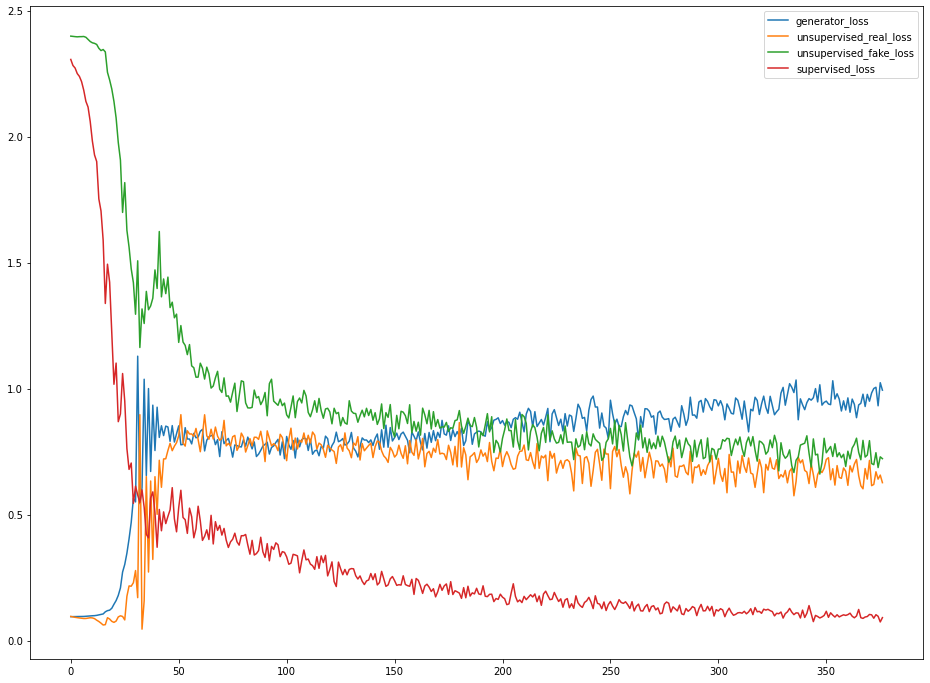

In [34]:
fig = log_file[["generator_loss", "unsupervised_real_loss", "unsupervised_fake_loss", "supervised_loss"]].plot(figsize=(16,12)).get_figure()
fig.savefig(f'{LOG_PATH}GAN_loss.png')

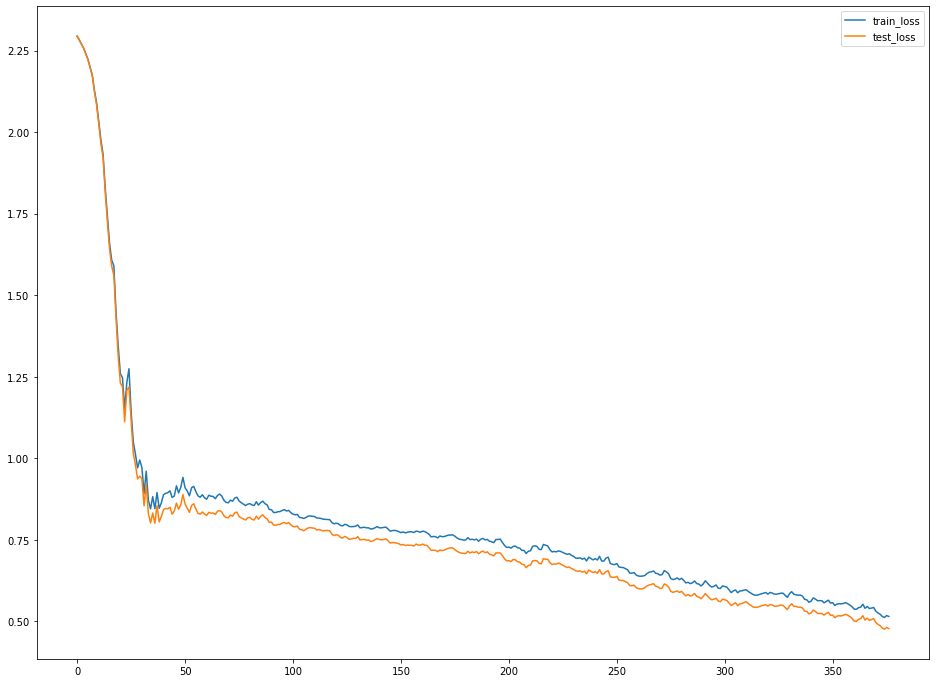

In [35]:
fig = log_file[["train_loss", "test_loss"]].plot(figsize=(16,12)).get_figure()
fig.savefig(f'{LOG_PATH}train_test_loss.png')

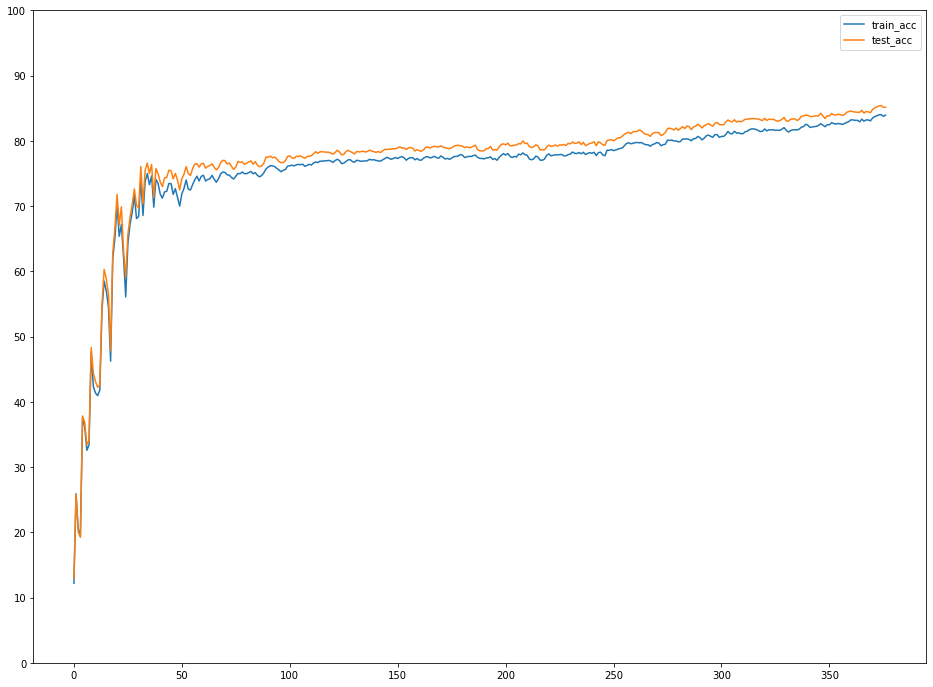

In [36]:
fig = log_file[["train_acc", "test_acc"]].plot(figsize=(16,12), ylim=(0,100), yticks=range(0,110,10)).get_figure()
fig.savefig(f'{LOG_PATH}train_test_acc.png')

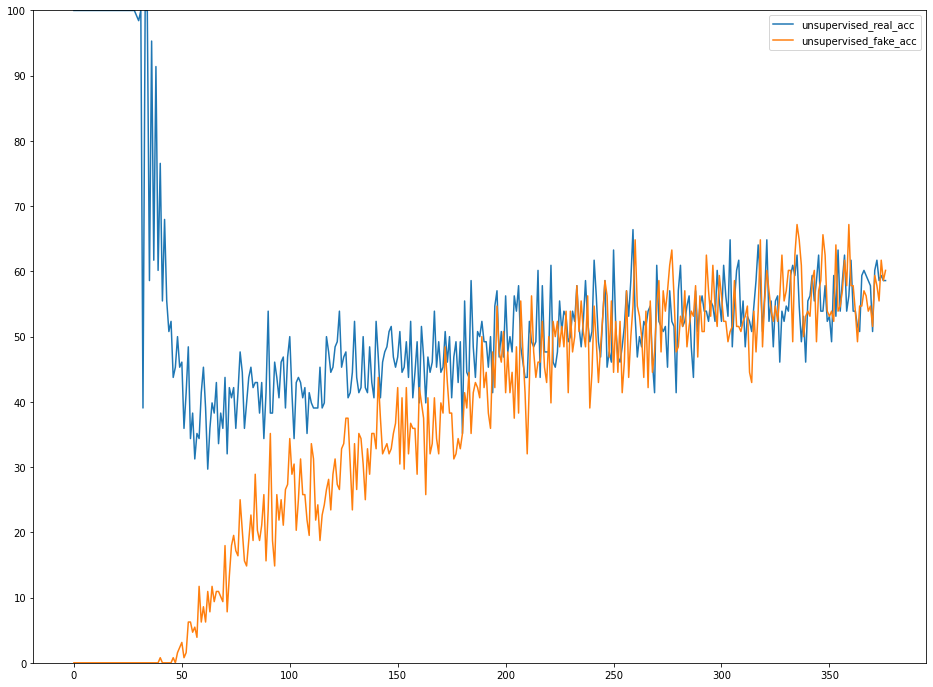

In [37]:
fig = log_file[["unsupervised_real_acc", "unsupervised_fake_acc"]].plot(figsize=(16,12), ylim=(0,100), yticks=range(0,110,10)).get_figure()
fig.savefig(f'{LOG_PATH}unsupervised_real_fake_acc.png')